In [1]:
#!pip install mpl_interactions
#!pip install ipympl
# NOTE: restart kernel after installing ipympl

In [2]:
#%matplotlib ipympl # похоже, что без разницы что использовать %matplotlib ipympl или %matplotlib widget
%matplotlib widget

In [3]:
# в этом ноутбуке попробую посмотреть как скользящий стоп лосс повлияет на прибыльность сделок.
# сначала проведу анализ для рандомных сделок.
# потом повторю для трейдов по прогнозам.

In [4]:
trade_period = 10 # время каждой сделки 10 минут
sl = -0.02 * 0.01 # стоп-лосс 0.02%
tp = 0.06 * 0.01 # тейк-профит в 3 раза больше СЛ

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import random
import forecast
from mpl_interactions import panhandler, zoom_factory

plt.rcParams['figure.figsize'] = [12, 5] # графики побольше

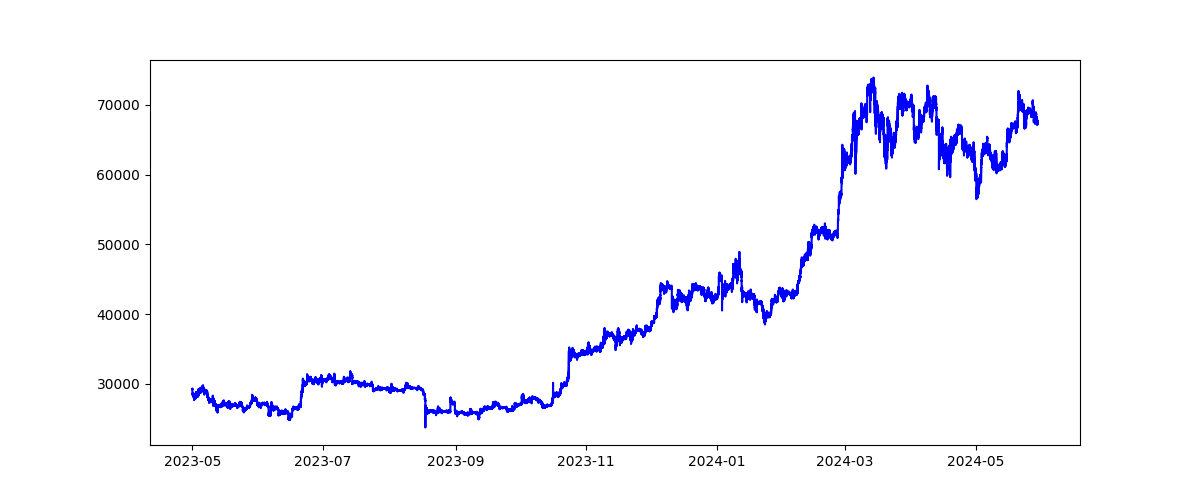

In [6]:
df = forecast.get_df('BTCUSD', '', '1T')
o = df['open']
# построю график, чтобы убедиться, что все загрузилось верно.
fig, ax = plt.subplots()
ax.plot(o, 'b-')

In [7]:
# сначала посчитаю профиты без стоп-лоссов и тейк-профитов.
profits = {}
L = len(o) - trade_period
for i in range(L):
  if i % ((int)(L/100)) == 0:
    print('\rProgress: ', round(i/L * 100), '%', end='')
  profit = round(o[i] - o[i + trade_period])
  profit = profit - (profit % 10)
  if profit in profits:
    profits[profit] += 1
  else:
    profits[profit] = 1
print('\ndone.')

Progress:  4 %

/tmp/ipykernel_269600/3425693851.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit = round(o[i] - o[i + trade_period])


Progress:  100 %
done.


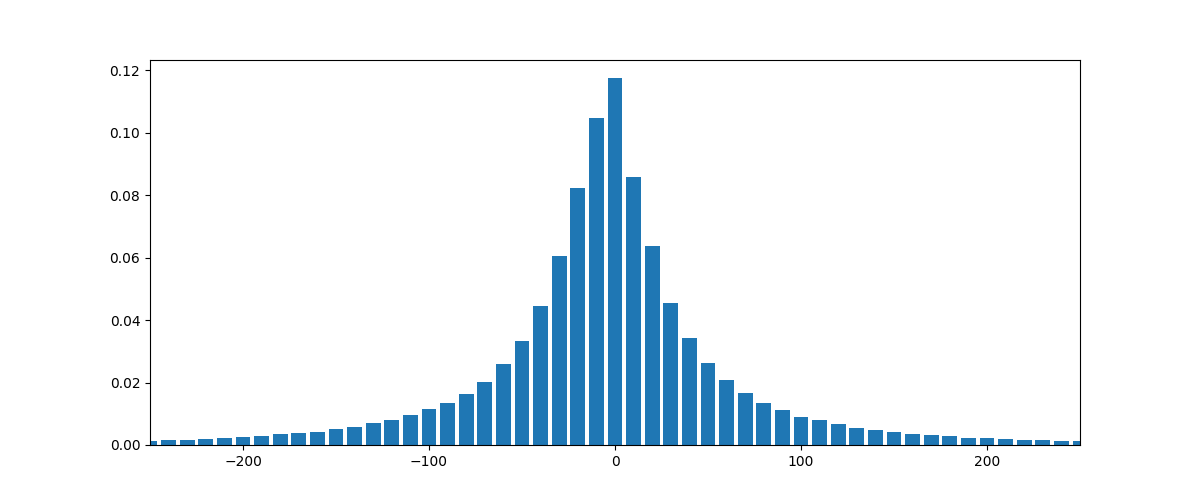

profit per trade:  -4.8668600562587905


In [8]:
# построю распределение
X = []
Y = []
cnt = 0
for p in profits:
  cnt += profits[p]
  X.append(p)
X.sort()
t = 0 # суммарный профит по всем сделкам.
for p in X:
  Y.append(profits[p] / ((float)(cnt)))
  t += p * profits[p]
fig, ax = plt.subplots()
ax.bar(X, Y, width=8)
xlim = 250
ax.set_xlim([-xlim, xlim])

# Добавляем интерактивность
panhandler(fig)
zoom_factory(ax)

plt.show()

# поделю суммарный профит по всем сделкам на количество сделок.
print('profit per trade: ', t/len(o))

In [9]:
# теперь посчитаю то же самое, но со стоп-лоссами.
# считать буду только для лонг сделок, т.к. в предыдущих экспериментах
# выяснилось, что при достаточно большом промежутке исходных данных
# распределения получаются симметричными с точностью до погрешности.
def get_profits(stop_loss, take_profit, sliding_stop_loss):
  assert stop_loss <= 0, 'stop_loss must be zero or negative!'
  assert take_profit >= 0, 'take_profit must be zero or positive!'
  assert sliding_stop_loss <= 0, 'sliding_stop_loss must be zero or negative!'
  profits = {}
  # -trade_period, чтобы не выйти за границы массива
  L = len(o) - trade_period
  #import ipdb; ipdb.set_trace()
  for i in range(L):
    if i % ((int)(L/100)) == 0:
      print('\rProgress: ', round(i/L * 100), '%', end='')
    oi = o[i]
    # буду запоминать максимум, чтобы от него
    # считать размер скользящего стоп-лосса.
    m = oi #
    # перебираю моменты времени от открытия до закрытия.
    for k in range(1, trade_period + 1):
      ok = o[i + k]
      m = ok if ok > m else m # вычисляю максимум
      # для лонга профит будет равен закрытие минус открытие.
      profit = round(ok - oi)
      # округлим профит до 10
      profit = profit - (profit % 10)
      if stop_loss < 0 and profit < oi * stop_loss:
        # считаю, что позиция закрыта ровно в момент достижения стоп-лоса.
        # не забываю, что значение stop_loss отрицательное!
        profit = round(oi * stop_loss)
        # округлим профит до 10
        profit = profit - (profit % 10)
        break
      if take_profit > 0 and profit > oi * take_profit:
        profit = round(oi * take_profit)
        # округлим профит до 10
        profit = profit - (profit % 10)
        break
      if sliding_stop_loss < 0 and ok - m < oi * sliding_stop_loss:
        # чтобы получить цену закрытия,
        # от максимума вычтем скользящий стоп-лосс.
        # не забываем, что sliding_stop_loss уже отрицателен.
        profit = round((m + oi * sliding_stop_loss) - oi)
        # округлим профит до 10
        profit = profit - (profit % 10)
        break
    if profit in profits:
      profits[profit] += 1
    else:
      profits[profit] = 1
  print('\nget_profits completed.')
  return profits

# построю распределение
def plot(profits):
  X2 = [] # неудачный нейминг, т.к. X уже занят в глобальном скоупе
  Y2 = [] # но переделывать лень.
  cnt2 = 0
  for p in profits:
    cnt2 += profits[p]
    X2.append(p)
  X2.sort()
  t2 = 0
  for p in X2:
    Y2.append(profits[p] / cnt2)
    t2 += p * profits[p]
  fig, ax = plt.subplots()
  ax.bar(X, Y, color='b', width=8)
  ax.bar(X2, Y2, color='r', width=8)
  ax.set_xlim([-xlim, xlim])
  # поделю суммарный профит по всем сделкам на количество сделок.
  print('profit per trade: ', t2/len(o), 'len(o) = ', len(o))
  assert cnt == cnt2, \
    'количество сделок должно совпадать с количеством сделок без СЛ и ТП'

print('ok')

ok


In [10]:
# скользящие стоп-лоссы без тейк-профитов
profits = get_profits(0, 0, -0.02 * 0.01)

Progress:  1 %

/tmp/ipykernel_269600/3625659567.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  oi = o[i]
/tmp/ipykernel_269600/3625659567.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ok = o[i + k]


Progress:  100 %
get_profits completed.


In [11]:
# размер комиссии без скидок на OKX 0.07%
0.07*0.01*70000

49.00000000000001

profit per trade:  11.940611814345992 len(o) =  568800


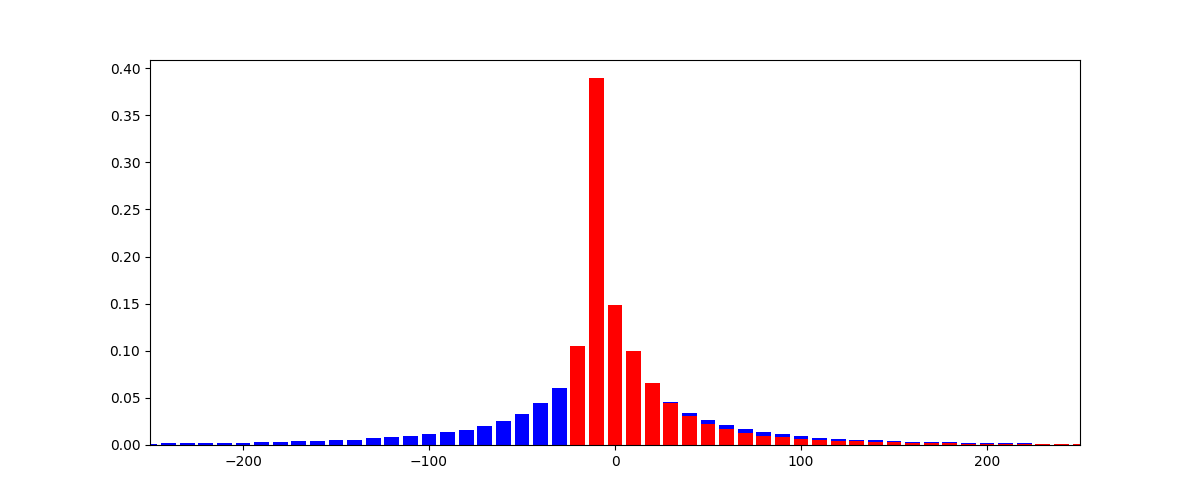

In [12]:
plot(profits)

In [13]:
def simulate(close_after, sliding_stop_loss, fees):
  profits = []
  total_profit = 0
  i = 0
  L = len(o) - close_after
  for i in range(L):
    if i % ((int)(L/100)) == 0:
      print('\rProgress: ', round(i/L * 100), '%', end='')
    trade_profit = 0
    oi = o[i]
    m = oi #
    for k in range(1, close_after + 1):
      ok = o[i+k]
      m = ok if ok > m else m # вычисляю максимум
      # надо из цены закрытия вычесть цену открыия.
      trade_profit = round(ok - oi)
      if sliding_stop_loss < 0 and ok - m < oi * sliding_stop_loss:
        # чтобы получить цену закрытия для скользящего стоп-лосса
        # надо от максимума вычесть размер скользящего стоп-лосса.
        # учитываем то, что уже sliding_stop_loss отрицательный!
        trade_profit = round((m + oi * sliding_stop_loss) - oi)
        break
    total_profit += trade_profit - fees
    profits.append(total_profit)
  print('\ndone')
  return profits

In [14]:
# закрывать после 10 минут.
# скользящий стоп-лосс на 0.01%.
profits = simulate(10, -0.01 * 0.01, 49)

Progress:  1 %

/tmp/ipykernel_269600/477423985.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  oi = o[i]
/tmp/ipykernel_269600/477423985.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ok = o[i+k]


Progress:  100 %
done


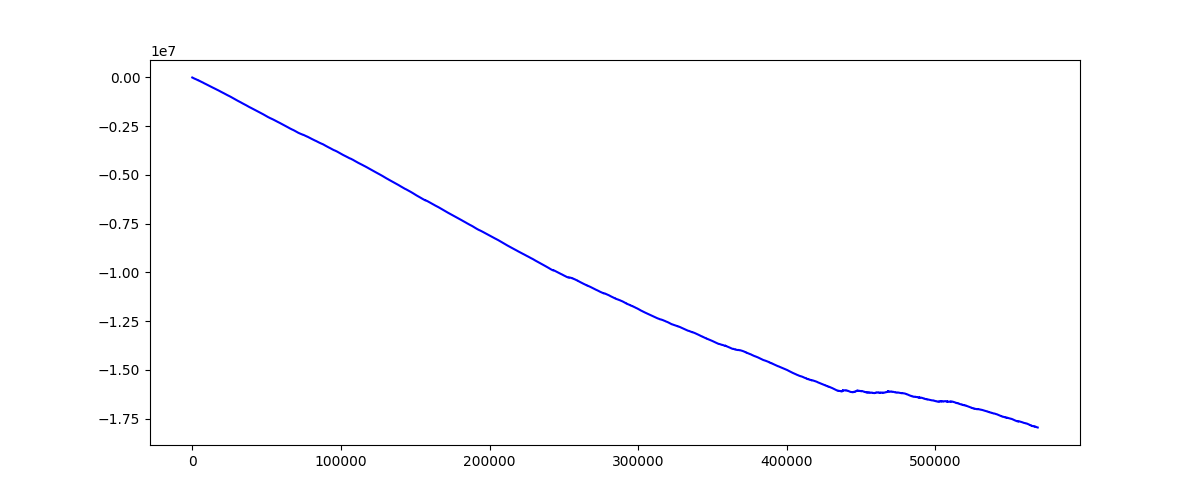

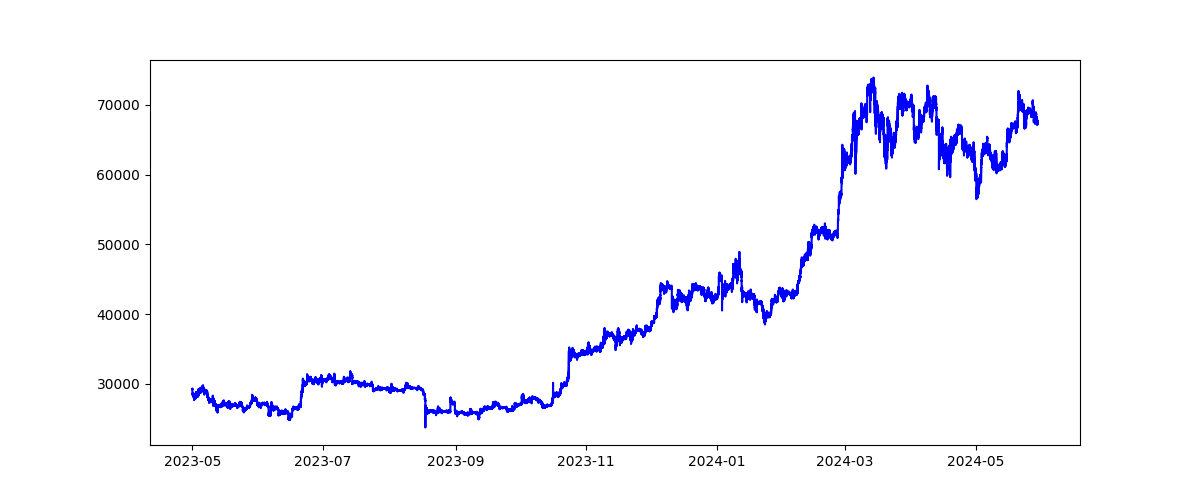

In [15]:
fig, ax = plt.subplots()
ax.plot(profits, 'b-')
#ax.set_xlim([25, 2555])
fig, ax = plt.subplots()
ax.plot(o, 'b-')